<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Final Project for "Classification with Python"</font></h1>
<h1 align="center"><font size="3">Hannah Reber, 2020</font></h1>

#### Imports

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import pydotplus
import pylab as pl
import scipy.optimize as opt
from IPython.display import Image  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics 
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from six import StringIO  

### About the dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [23]:
# load dataest
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [24]:
df.shape

(346, 10)

### Convert to date time object 

In [25]:
# due_date + effective_date to datetime dtype
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [26]:
# overview loan_status
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

# Data visualization and pre-processing



260 people have paid off the loan on time while 86 have gone into collection 


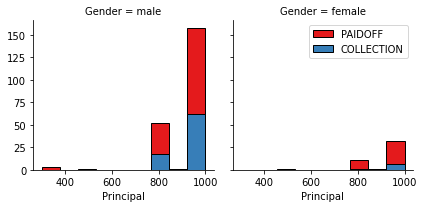

In [27]:
# plot principal (= loan paidoff + collection) per gender

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

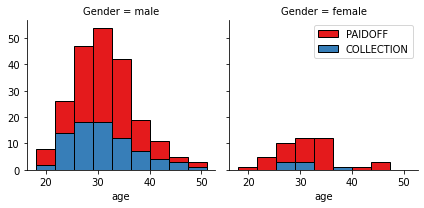

In [28]:
# plot principal (paidoff+collection) for ages (bins per 10 years)

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


# Pre-processing:
## Feature Selection & Categorical Features dtype Convertion

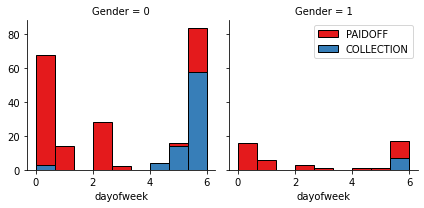

In [33]:
# plot paidoff-status per dayofweek (of effective_date) per gender

df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()
            # plot shows: much more paidoffs in the beginning of week, much less on weekends
            # decision: integrate dayofweek of effective_date as new col into df

In [34]:
# new col dayofweek (of effective_date)
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [31]:
# overview load status per gender
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
    # shows: gender relevant -> keeping col for analysis

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [32]:
# make gender numeric
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [35]:
# overview laonstatus per education category
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
    # looks chaotic 
    # -> review in combination with principal, age, gender and terms (= Origination terms which can be: 
                                                        # I. weekly,  II. biweekly, III. monthly payoff schedule)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [36]:
# pick selected cols
df[['Principal','terms','age','Gender','education']].head(2)

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [37]:
# define rawdf and make it pretty

rawdf = df[['loan_status', 'Principal','terms','age','Gender','weekend']]
rawdf = pd.concat([rawdf,pd.get_dummies(df['education'])], axis=1)
rawdf.drop(['Master or Above'], axis = 1,inplace=True)
rawdf['PAIDOFF_1'] = [1 if x == "PAIDOFF" else 0 for x in rawdf['loan_status'].to_list()]
rawdf['Label_1Paidoff'] = rawdf['PAIDOFF_1'].astype(int)
rawdf = rawdf.drop(columns={'PAIDOFF_1'})
rawdf =rawdf.rename(columns={'terms':'Terms', 'age': 'Age','weekend': 'Weekend','Bechalor':'Edu3_BA','High School or Below':'Edu1_HighSnBelow','college':'Edu2_Collage' })
rawdf = rawdf.drop(columns={'loan_status'})
rawdf.head()
df = rawdf.copy()

### Feature selection

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [38]:
# define selected cols as Feature called df
Feature = df[[x for x in rawdf.columns if x != "Label_1Paidoff"]]
Feature.head(2)

,Principal,Terms,Age,Gender,Weekend,Edu3_BA,Edu1_HighSnBelow,Edu2_Collage
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0


In [39]:
# define X = feature selection = Feature df

X = Feature

# define labels = y = PAIDOFF / COLLECTION
y = df['Label_1Paidoff'].values

# normalize via stand scal
X= preprocessing.StandardScaler().fit(X).transform(X)

# Classification 

In [41]:
# initialize storages for model accurancy values
modelaccs = {'KNN':None, 'DTree':None, 'SVM':None, 'LogReg':None}

# 1) K Nearest Neighbor / KNN

In [23]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print('\nTrain set:\t', X_train.shape,  y_train.shape)
print('\nTest set:\t', X_test.shape,  y_test.shape)


Train set:	 (276, 8) (276,)

Test set:	 (70, 8) (70,)


In [26]:
# calculating the accuracy for different K - starting with hughe number = 100

Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):   
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)   
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       , 0.72857143,
       0.71428571, 0.77142857, 0.68571429, 0.78571429, 0.75714286,
       0.78571429, 0.74285714, 0.78571429, 0.78571429, 0.78571429,
       0.75714286, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.77142857, 0.77142857, 0.77142857, 0.78571429, 0.77142857,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571

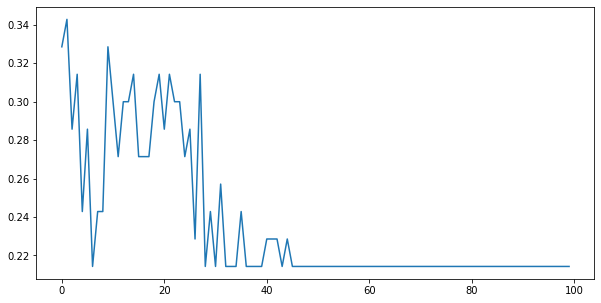

In [27]:
# predictions

error_rates = []
matches = []
for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))
    matches.append(y_test)
plt.figure(figsize=(10,5))
plt.plot(error_rates)

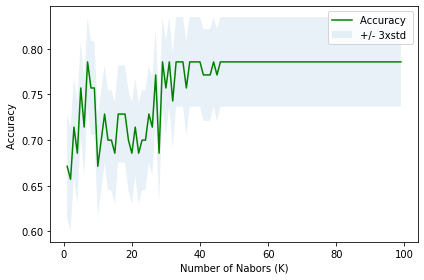

In [28]:
# plot accuracy

Ks = 100
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show() # plot shows overfitting starts around k = 30

In [29]:
# print solution for best k

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


In [31]:
# accuracy for k = 7

k = 7
neigh7 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat7 = neigh7.predict(X_test)
print("Train set accuracy: \t", metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print("Test set accuracy: \t", metrics.accuracy_score(y_test, yhat7))

Train set accuracy: 	 0.8079710144927537
Test set accuracy: 	 0.7857142857142857


## KNN ACCURACY

- **TEST  0.7857142857142857**
- TRAIN   0.8079710144927537

In [196]:
############################################################ ############################################################
############################################################ ############################################################

# updating accurancy dict and review

modelaccs['KNN'] = 0.7857142857142857
modelaccs['KNN_train'] = 0.8079710144927537 
modelaccs

{'KNN': 0.7857142857142857,
 'DTree': 0.6538461538461539,
 'SVM': 0.7403846153846154,
 'LogReg': 0.6857142857142857,
 'KNN_train': 0.8079710144927537,
 'DTree_train': 0.756198347107438,
 'SVM_train': 0.743801652892562,
 'LogReg_train': 7572463768115942}

In [50]:
print(classification_report(y_test, yhat7))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



In [51]:
print(confusion_matrix(y_test, predictions))

[[ 6  9]
 [ 6 49]]


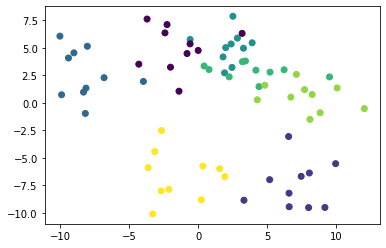

In [52]:
raw_data = make_blobs(n_samples = 70, n_features = 2, centers = 7, cluster_std = 1.8)
plt.scatter(raw_data[0][:,0], raw_data[0][:,1], c=raw_data[1])

In [65]:
###################################
# compare to KMeans

model = KMeans(n_clusters=7)
model.fit(raw_data[0])
model.labels_
model.cluster_centers_

array([[ 8.88359648, -0.03893324],
       [-1.99543215,  4.65586647],
       [-1.34309282, -6.6029897 ],
       [-8.63338926,  2.68897121],
       [ 5.3714752 ,  1.90301595],
       [ 7.14801617, -7.89833867],
       [ 2.42794759,  4.48406423]])

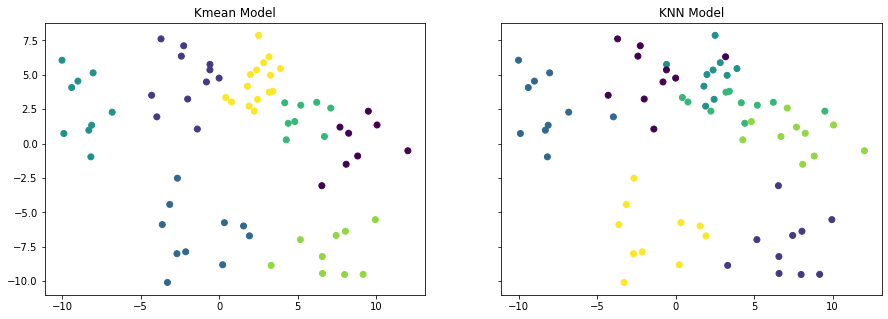

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))
ax1.set_title('Kmean Model')
ax1.scatter(raw_data[0][:,0], raw_data[0][:,1],c=model.labels_)
ax2.set_title('KNN Model')
ax2.scatter(raw_data[0][:,0], raw_data[0][:,1],c=raw_data[1])

# 2) Decision Tree

In [86]:
df.shape

(346, 9)

In [105]:
# split
X = df[['Principal', 'Terms', 'Age', 'Gender', 'Weekend', 'Edu3_BA','Edu1_HighSnBelow', 'Edu2_Collage']].values
y = df["Label_1Paidoff"]
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

clf = DecisionTreeClassifier(random_state=0)

In [134]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

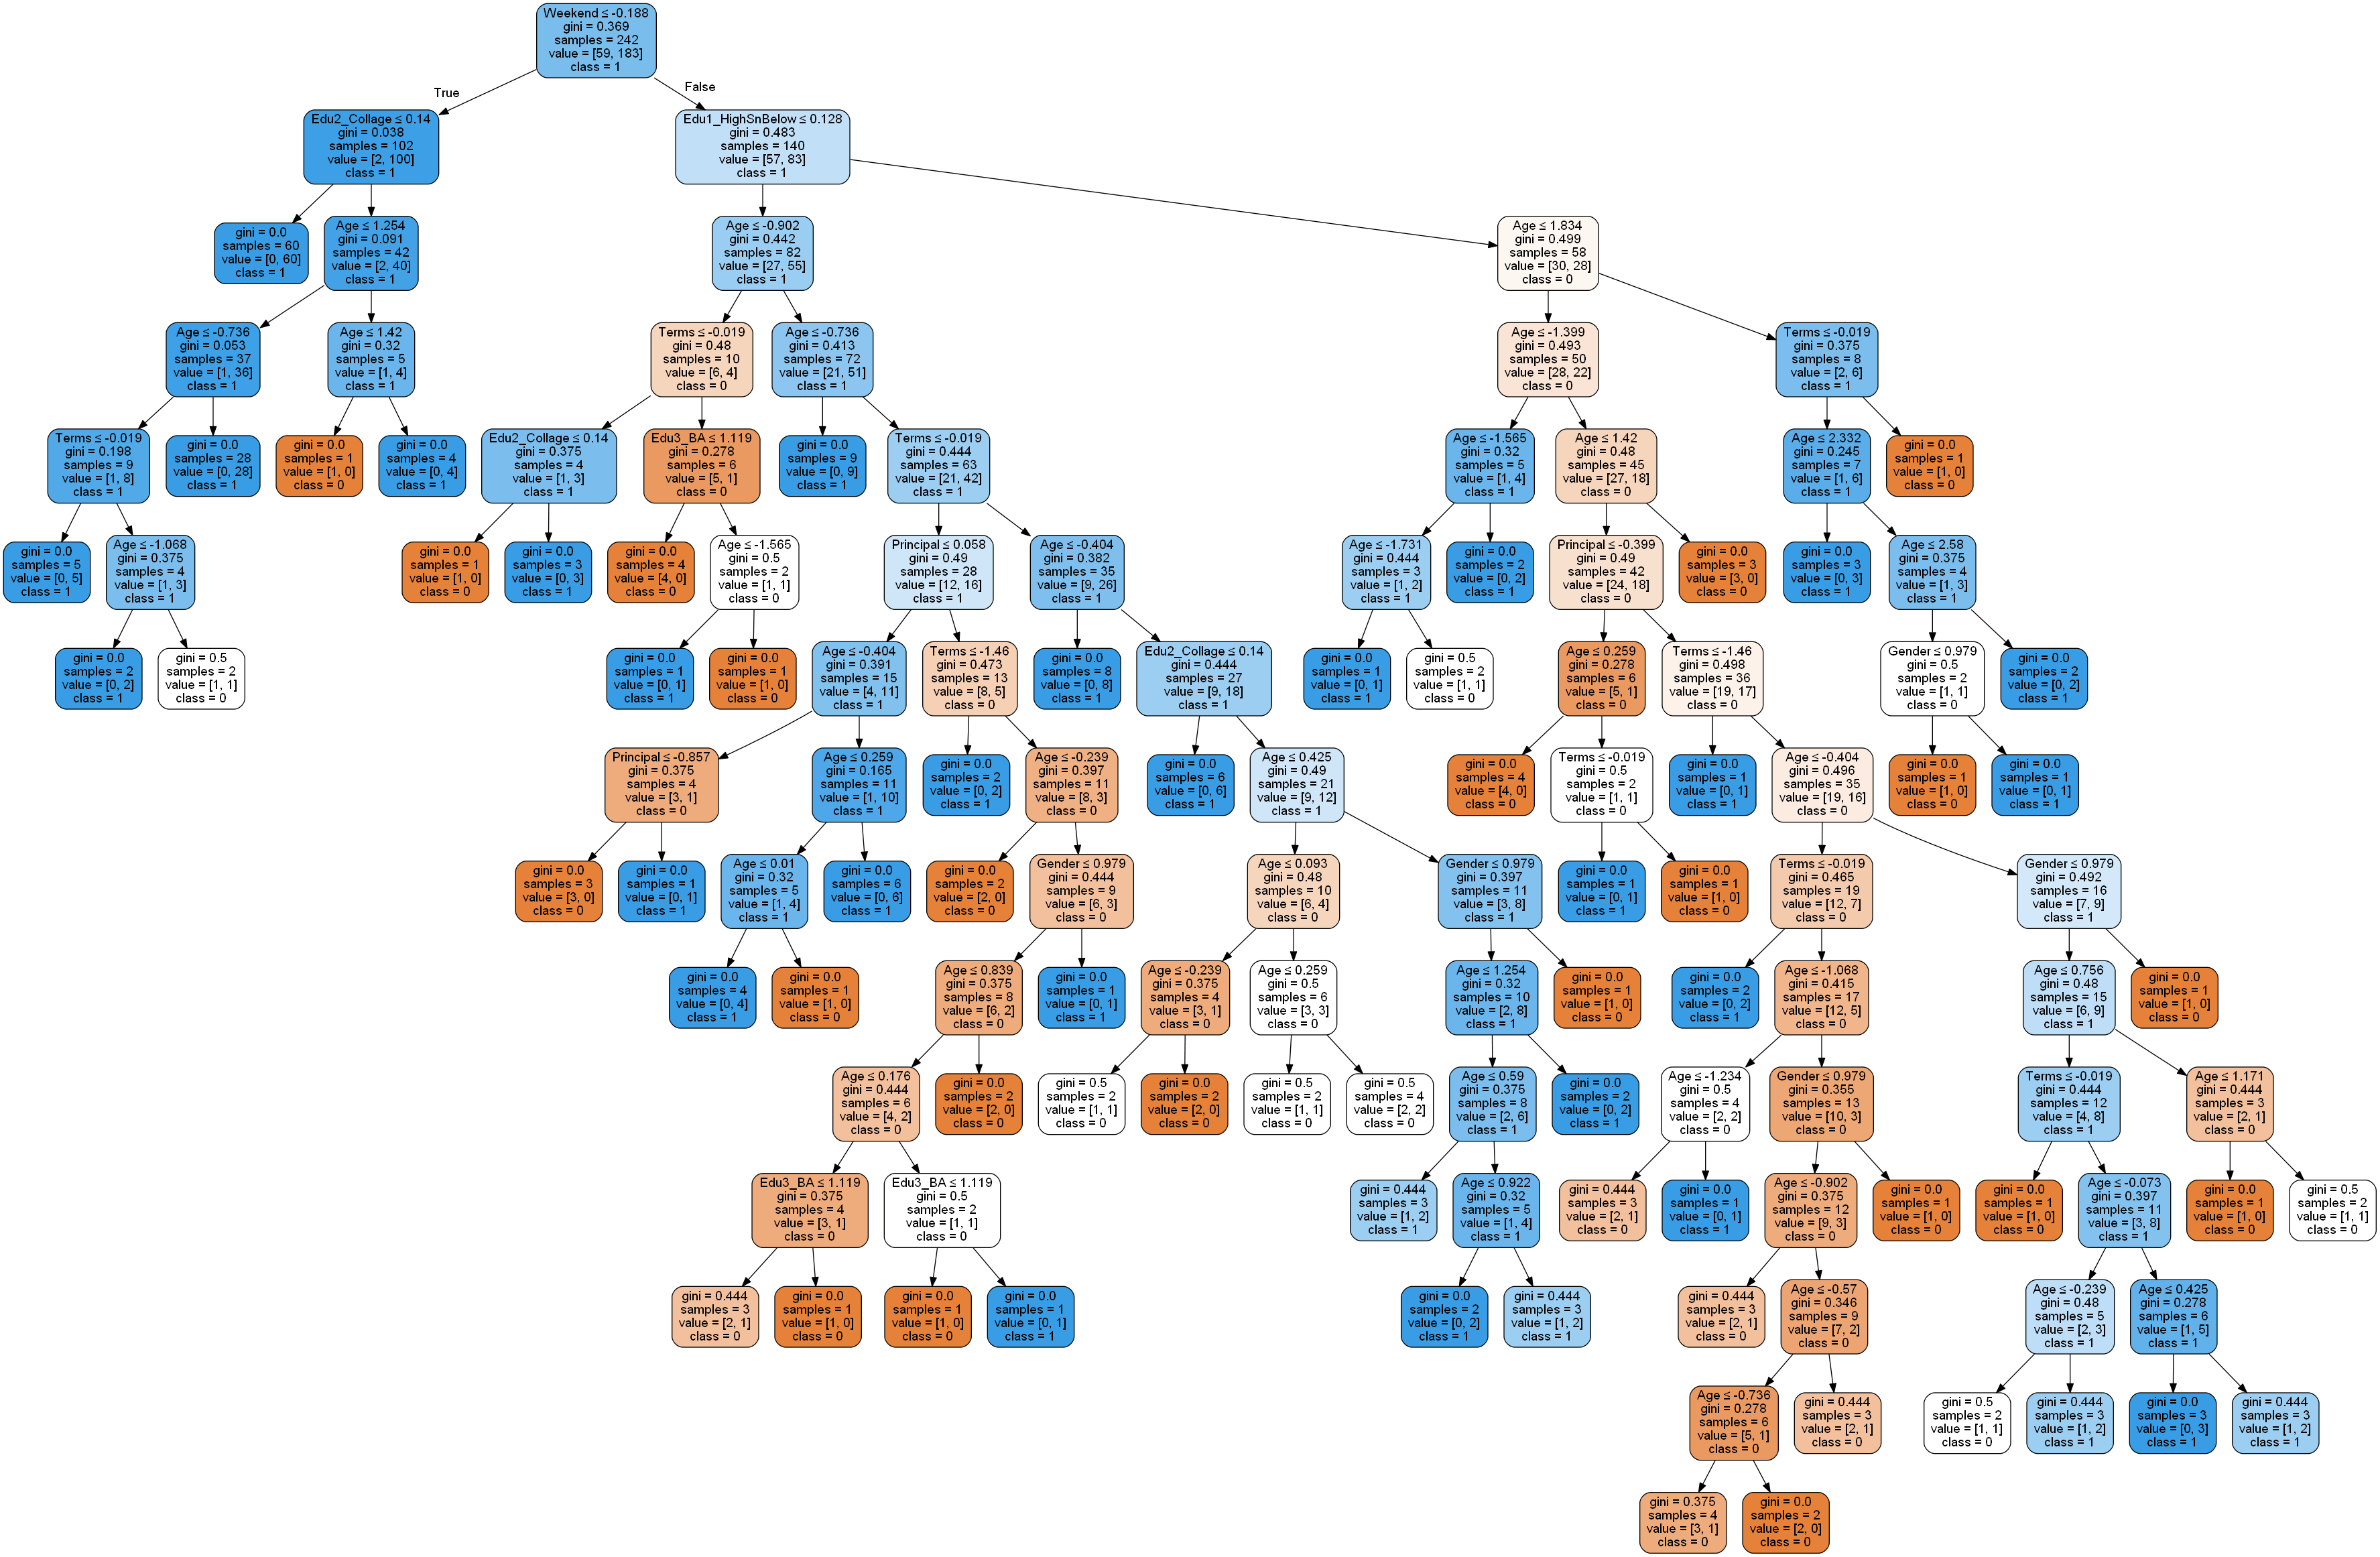

In [135]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [136]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6730769230769231


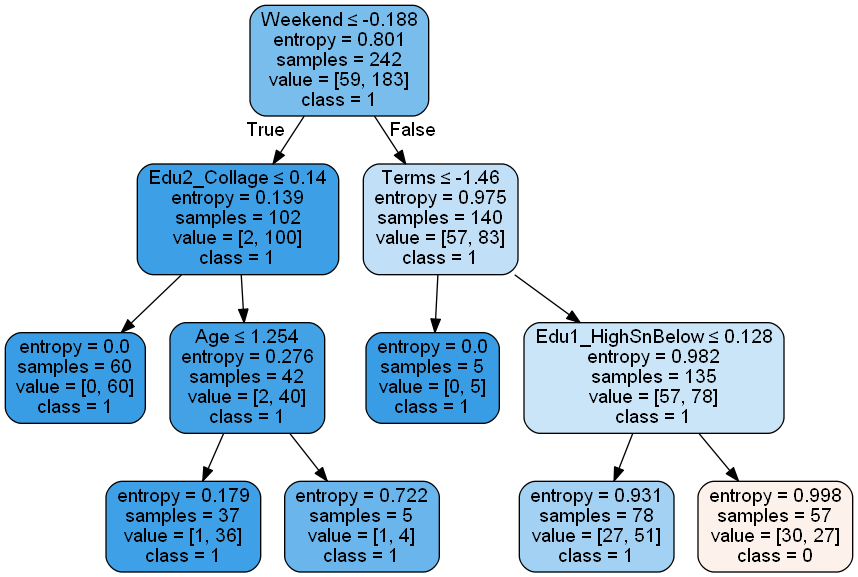

In [138]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree2.png')
Image(graph.create_png())

In [140]:
# accuracy

print("Train set accuracy: \t", metrics.accuracy_score(y_train, payTree.predict(X_train)))
print("Test set accuracy: \t", metrics.accuracy_score(y_testset, predTree))

Train set accuracy: 	 0.756198347107438
Test set accuracy: 	 0.6538461538461539


## Decision Tree ACCURACY

- **TEST  0.6538461538461539**
- TRAIN   0.756198347107438

In [198]:
############################################################ ############################################################
############################################################ ############################################################

# updating accurancy dict and review

modelaccs['DTree'] = 0.6538461538461539
modelaccs['DTree_train'] = 0.756198347107438
modelaccs

{'KNN': 0.7857142857142857,
 'DTree': 0.6538461538461539,
 'SVM': 0.7403846153846154,
 'LogReg': 0.6857142857142857,
 'KNN_train': 0.8079710144927537,
 'DTree_train': 0.756198347107438,
 'SVM_train': 0.743801652892562,
 'LogReg_train': 7572463768115942}

# 3) Support Vector Machine

In [143]:
#split dataset in features and target variable

feature_cols = Feature.columns
X = df[feature_cols] # Features
y = df.Label_1Paidoff # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [148]:
#Create a svm Classifier

clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
clf_y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, clf_y_pred))

Accuracy: 0.7692307692307693


In [149]:
# accuracy

print("Train set accuracy: \t", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set accuracy: \t", metrics.accuracy_score(y_testset, clf_y_pred))

Train set accuracy: 	 0.743801652892562
Test set accuracy: 	 0.7403846153846154


## Support Vector Machine ACCURACY

- **TEST  0.7403846153846154**
- TRAIN   0.743801652892562

In [150]:
############################################################ ############################################################
############################################################ ############################################################

# updating accurancy dict and review

modelaccs['SVM'] = 0.7403846153846154
modelaccs['SVM_train'] = 0.743801652892562
modelaccs

{'KNN': 0.7857142857142857,
 'DTree': 0.6538461538461539,
 'SVM': 0.7403846153846154,
 'LogReg': None,
 'KNN_train': 0.8079710144927537,
 'DTree_train': 0.756198347107438,
 'SVM_train': 0.743801652892562}

# 4) Logistic Regression

In [155]:
# split and prepare test and train

X = np.asarray(df[feature_cols])
y = np.asarray(df['Label_1Paidoff'])
X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [156]:
# model
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [188]:
# predictions
lr_yhat = LR.predict(X_test)
lr_yhat_prob = LR.predict_proba(X_test)

# score
jaccard_score(y_test, lr_yhat)

0.6764705882352942

In [189]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, lr_yhat, labels=[1,0]))

[[46  9]
 [13  2]]


Confusion matrix, without normalization
[[46  9]
 [13  2]]


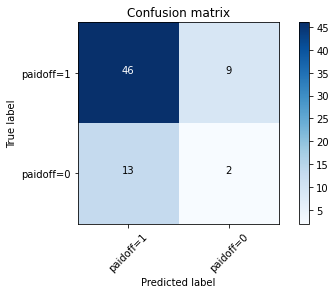

In [190]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, lr_yhat, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['paidoff=1','paidoff=0'],normalize= False,  title='Confusion matrix')

In [191]:
# see report
print(classification_report(y_test, lr_yhat))

              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [192]:
# see loss
log_loss(y_test, lr_yhat_prob)

0.5772287609479654

In [186]:
# accuracy training

# predictions training
lr_trainy = LR.predict(X_train)
lr_trainy_prob = LR.predict_proba(X_train)
# score training
jaccard_score(y_train, lr_trainy)

0.7351778656126482

In [193]:
# accuracy train and test

print("Accuracy Train:",metrics.accuracy_score(y_train, lr_trainy))
print("Accuracy Test:",metrics.accuracy_score(y_test, lr_yhat))

Accuracy Train: 0.7572463768115942
Accuracy Test: 0.6857142857142857


## Logistic Regression ACCURACY

- **TEST  0.6857142857142857**
- TRAIN   0.7572463768115942

In [175]:
############################################################ ############################################################
############################################################ ############################################################

# updating accurancy dict and review

modelaccs['LogReg'] = 0.6857142857142857
modelaccs['LogReg_train'] = 0.7572463768115942

############################################################ ############################################################
############################################################ ############################################################


# SUMMARY

## Review Accurany Measurements

In [370]:
# dict with all accurancies
a = {'KNN_test': 0.7857142857142857, 'DTree_test': 0.6538461538461539, 'SVM_test': 0.7403846153846154, 'LogReg_test': 0.6857142857142857, 'KNN_train': 0.8079710144927537,
     'DTree_train': 0.756198347107438, 'SVM_train': 0.743801652892562, 'LogReg_train': 0.7572463768115942}

In [371]:
# lists from dict
accurancy = [round(x,4) for x in a.values()]
modelset = [x for x in a.keys()]
accurancy

[0.7857, 0.6538, 0.7404, 0.6857, 0.808, 0.7562, 0.7438, 0.7572]

In [372]:
# res(ult)df
d = {'Set':modelset, 'Accurancy': accurancy}
resdf = pd.DataFrame(d)

In [373]:
# make readf pretty
resdf['Model'] = [x.split("_")[0] for x in resdf['Set']]
resdf['Run'] = [x.split('_')[1] for x in resdf['Set']]
resdf.head()

,Set,Accurancy,Model,Run
0,KNN_test,0.7857,KNN,test
1,DTree_test,0.6538,DTree,test
2,SVM_test,0.7404,SVM,test
3,LogReg_test,0.6857,LogReg,test
4,KNN_train,0.8080,KNN,train


In [374]:
############################################################ ############################################################ 
############################################################ ############################################################ 

# TEST ACCURANCY

testresults = pd.DataFrame(resdf.loc[resdf['Run']=='test'])
testresults = testresults.sort_values('Accurancy', ascending = False)
testresults = testresults.rename(columns= {'Accurancy': 'Accurancy_Test'})
testresults = testresults.set_index('Model')
testresults

,Set,Accurancy_Test,Run
Model,,,
KNN,KNN_test,0.7857,test
SVM,SVM_test,0.7404,test
LogReg,LogReg_test,0.6857,test
DTree,DTree_test,0.6538,test


In [377]:
############################################################ ############################################################
############################################################ ############################################################

# TRAINING ACCURANCY

trainresults = pd.DataFrame(resdf.loc[resdf['Run']=='train'])
trainresults = trainresults.sort_values('Accurancy', ascending = False)
trainresults = trainresults.rename(columns= {'Accurancy': 'Accurancy_Training'})
trainresults = trainresults.set_index('Model')
trainresults

,Set,Accurancy_Training,Run
Model,,,
KNN,KNN_train,0.8080,train
LogReg,LogReg_train,0.7572,train
DTree,DTree_train,0.7562,train
SVM,SVM_train,0.7438,train


In [280]:
############################################################ ############################################################
############################################################ ############################################################

# ACCURANCY DIFFERENCES

# summary df for results
summary = pd.DataFrame([trainresults.Accurancy_Training,testresults.Accurancy_Test])

# get differences
lcoldiffs = []
modelids = []
for col in summary.columns:
    mid = col
    vals = [ x for x in summary[x].to_list()]
    coldiff = vals[0] -vals[1]
    lcoldiffs.append(coldiff)
    modelids.append(mid)

# temp(oray)df1 for results
tdf1 = pd.DataFrame({"Model":modelids, "Accurancy_Difference": lcoldiffs})
tdf1 = tdf.set_index('Model')

# temp(oray)df2 for differences
tdf2 = summary.reset_index()
tdf2 = pd.pivot_table(ndf, columns = ndf['index'])

# join temp dfs to final df
final = ndf.join(tdf)

,index,KNN,LogReg,DTree,SVM
0,Accurancy_Training,0.8080,0.7572,0.7562,0.7438
1,Accurancy_Test,0.7857,0.6857,0.6538,0.7404


In [378]:
# see results
final

,Accurancy_Test,Accurancy_Training,Accurancy_Difference
DTree,0.6538,0.7562,0.0223
KNN,0.7857,0.8080,0.0223
LogReg,0.6857,0.7572,0.0223
SVM,0.7404,0.7438,0.0223
